In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn as nn
from torchvision import datasets,transforms
import torch.nn.functional as F
import sys
sys.path.append("../code/")
from dataloader import APPLIANCE_ORDER, get_train_test
from sklearn.metrics import mean_absolute_error
import os

In [2]:
cuda_av = False
if torch.cuda.is_available():
    cuda_av = True

torch.manual_seed(0)
np.random.seed(0)

In [3]:

class CustomRNN(nn.Module):
    def __init__(self, cell_type, hidden_size, num_layers, bidirectional):
        super(CustomRNN, self).__init__()
        torch.manual_seed(0)

        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1
        if cell_type == "RNN":
            self.rnn = nn.RNN(input_size=1, hidden_size=hidden_size,
                              num_layers=num_layers, batch_first=True,
                              bidirectional=bidirectional)
        elif cell_type == "GRU":
            self.rnn = nn.GRU(input_size=1, hidden_size=hidden_size,
                              num_layers=num_layers, batch_first=True,
                              bidirectional=bidirectional)
        else:
            self.rnn = nn.LSTM(input_size=1, hidden_size=hidden_size,
                               num_layers=num_layers, batch_first=True,
                               bidirectional=bidirectional)

        self.linear = nn.Linear(hidden_size * self.num_directions, 1)
        self.act = nn.ReLU()

    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.linear(pred).view(pred.data.shape[0], -1, 1)
        pred = torch.min(pred, x)
        return pred

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=7, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(20)

        self.conv2 = nn.Conv2d(20, 16, kernel_size=2, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 64, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.ConvTranspose2d(64, 16, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(16)

        self.conv5 = nn.ConvTranspose2d(16, 6, kernel_size=4, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(6)

        self.conv6 = nn.ConvTranspose2d(6, 1, kernel_size=5, stride=1, padding=2) 
        
        self.act = nn.ReLU()
        
    # forward method
    def forward(self, input):
        
        e1 = self.conv1(input)
        bn1 = self.bn1(self.act(e1))
        e2 = self.bn2(self.conv2(bn1))        
        e5 = self.bn5(self.conv5(e2))
        e6 = self.conv6(e5)
        return e6

In [4]:
def preprocess(train, valid, test):
    out_train = [None for temp in range(len(ORDER))]
    for a_num, appliance in enumerate(ORDER):
        out_train[a_num] = Variable(
            torch.Tensor(train[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((train.shape[0], 1, -1, 24))))
        if cuda_av:
            out_train[a_num] = out_train[a_num].cuda()

    out_valid = [None for temp in range(len(ORDER))]
    for a_num, appliance in enumerate(ORDER):
        out_valid[a_num] = Variable(
            torch.Tensor(valid[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((valid.shape[0], 1, -1, 24))))
        if cuda_av:
            out_valid[a_num] = out_valid[a_num].cuda()
            
    out_test = [None for temp in range(len(ORDER))]
    for a_num, appliance in enumerate(ORDER):
        out_test[a_num] = Variable(
            torch.Tensor(test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((test.shape[0], 1, -1, 24))))
        if cuda_av:
            out_test[a_num] = out_test[a_num].cuda()

    return out_train, out_valid, out_test

In [23]:
class AppliancesRNNCNN(nn.Module):
    def __init__(self, cell_type, hidden_size, num_layers, bidirectional, num_appliance):
        super(AppliancesRNNCNN, self).__init__()
        self.num_appliance = num_appliance
        self.preds = {}
        self.order = ORDER
        for appliance in range(self.num_appliance):
            if ORDER[appliance] in ['fridge']:
                print("use RNN")
                if cuda_av:
                    setattr(self, "Appliance_" + str(appliance), CustomRNN(cell_type, hidden_size,
                                                                           num_layers, bidirectional).cuda())
                else:
                    setattr(self, "Appliance_" + str(appliance), CustomRNN(cell_type, hidden_size,
                                                                           num_layers, bidirectional))
            else:
                print("use CNN")
                if cuda_av:
                    setattr(self, "Appliance_" + str(appliance), CustomCNN().cuda())
                else:
                    setattr(self, "Appliance_" + str(appliance), CustomCNN())


    def forward(self, *args):
        agg_current = args[0]
        flag = False
        if np.random.random() > args[1]:
            flag = True
        else:
            pass
        for appliance in range(self.num_appliance):
            agg_current = agg_current.contiguous()
            if ORDER[appliance] in ['fridge']:
                agg_current = agg_current.view(agg_current.shape[0], -1, 1)
            else:
                agg_current = agg_current.view(agg_current.shape[0], 1, -1, 24)
            
            self.preds[appliance] = getattr(self, "Appliance_" + str(appliance))(agg_current)
            
            agg_current = agg_current.view(agg_current.shape[0], 1, -1, 24)
            self.preds[appliance] = self.preds[appliance].view(self.preds[appliance].shape[0], 1, -1, 24)
            
            
            if flag:
                agg_current = agg_current - self.preds[appliance]
            else:
                agg_current = agg_current - args[2 + appliance]

        return torch.cat([self.preds[a] for a in range(self.num_appliance)])

In [24]:
dataset = 5
fold_num = 0
num_folds = 5
train, test = get_train_test(dataset, num_folds=num_folds, fold_num=fold_num)

In [25]:
valid = train[int(0.8*len(train)):].copy()
train = train[:int(0.8 * len(train))].copy()
train_aggregate = train[:, 0, :, :].reshape(train.shape[0], 1, -1, 24)
valid_aggregate = valid[:, 0, :, :].reshape(valid.shape[0], 1, -1, 24)
test_aggregate = test[:, 0, :, :].reshape(test.shape[0], 1, -1, 24)

In [26]:
ORDER = ['dr', 'fridge', 'residual', 'hvac','dw', 'mw']
# ORDER = ORDER[::-1]
out_train, out_valid, out_test = preprocess(train, valid, test)

In [27]:
inp = Variable(torch.Tensor(train_aggregate), requires_grad=False)
valid_inp = Variable(torch.Tensor(valid_aggregate), requires_grad=False)
test_inp = Variable(torch.Tensor(test_aggregate), requires_grad=False)
if cuda_av:
    inp = inp.cuda()
    valid_inp = valid_inp.cuda()
    test_inp = test_inp.cuda()
valid_out = torch.cat([out_valid[appliance_num] for appliance_num, appliance in enumerate(ORDER)])
test_out = torch.cat([out_test[appliance_num] for appliance_num, appliance in enumerate(ORDER)])
train_out = torch.cat([out_train[appliance_num] for appliance_num, appliance in enumerate(ORDER)])

In [30]:
loss_func = nn.L1Loss()
model = AppliancesRNNCNN('GRU', 20, 1, True, len(ORDER))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
p=0
params = [inp, p]

if cuda_av:
    model = model.cuda()
    loss_func = loss_func.cuda()
    
for a_num, appliance in enumerate(ORDER):
    params.append(out_train[a_num])

if cuda_av:
    train_out = train_out.cuda()

use CNN
use RNN
use CNN
use CNN
use CNN
use CNN


In [31]:
for k in range(500):
    pred = model(*params)
    optimizer.zero_grad()
    loss = loss_func(pred, train_out)
    
    
    
    if cuda_av:
        test_inp = test_inp.cuda()
    test_params = [test_inp, -2]
    for i in range(len(ORDER)):
        test_params.append(None)
    test_pr = model(*test_params)
    test_loss = loss_func(test_pr, test_out)
    
    print(k, loss.data[0], test_loss.data[0])

    loss.backward()
    optimizer.step()

0 369.40936279296875 314.42547607421875
1 369.3091735839844 314.3229064941406
2 369.2257080078125 314.2421569824219
3 369.1417541503906 314.15264892578125
4 369.0351867675781 314.0528259277344
5 368.9334411621094 313.9473571777344
6 368.8152160644531 313.8296813964844
7 368.68902587890625 313.6963806152344
8 368.5516357421875 313.5478820800781
9 368.39263916015625 313.3927001953125
10 368.2334289550781 313.2272033691406
11 368.0635070800781 313.0402526855469
12 367.8721923828125 312.8408508300781
13 367.67120361328125 312.6136169433594
14 367.46331787109375 312.3754577636719
15 367.23553466796875 312.1419677734375
16 367.00079345703125 311.86572265625
17 366.74884033203125 311.572998046875
18 366.4668273925781 311.2997131347656
19 366.155029296875 310.96527099609375
20 365.8193664550781 310.60467529296875
21 365.4669494628906 310.2644958496094
22 365.1281433105469 309.95330810546875
23 364.7938232421875 309.6231994628906
24 364.44085693359375 309.2851867675781
25 364.0695495605469 308.

205 165.53684997558594 128.76266479492188
206 164.99586486816406 128.25135803222656
207 165.313232421875 130.16567993164062
208 165.3806915283203 128.48004150390625
209 164.515869140625 129.47021484375
210 164.6901092529297 130.0256805419922
211 164.6347198486328 129.72496032714844
212 163.95166015625 129.0855712890625
213 163.85350036621094 130.22119140625
214 164.78704833984375 129.7771453857422
215 163.8086395263672 130.7563018798828
216 163.44229125976562 129.8839111328125
217 163.77145385742188 129.9287109375
218 162.8862762451172 130.06956481933594
219 162.9185333251953 130.01785278320312
220 163.5261688232422 131.28836059570312
221 163.57542419433594 130.67672729492188
222 163.92080688476562 132.60055541992188
223 163.74342346191406 130.43365478515625
224 162.5137481689453 130.4069061279297
225 164.2413787841797 133.26925659179688
226 163.70912170410156 130.10482788085938
227 162.41238403320312 130.066650390625
228 163.8252410888672 133.12132263183594
229 162.38218688964844 129.

406 155.07737731933594 139.29360961914062
407 155.27346801757812 140.5833282470703
408 154.5737762451172 138.1183624267578
409 154.40628051757812 139.59764099121094
410 154.54092407226562 139.31459045410156
411 153.71060180664062 138.42935180664062
412 154.12730407714844 139.3793487548828
413 154.12254333496094 138.23509216308594
414 153.67539978027344 138.78738403320312
415 153.91090393066406 138.94703674316406
416 153.4902801513672 139.1409149169922
417 153.807373046875 140.0607452392578
418 154.3007049560547 138.91400146484375
419 153.61065673828125 139.56373596191406
420 153.9405517578125 139.6192626953125
421 153.72315979003906 138.70571899414062
422 154.07447814941406 140.8489532470703
423 154.26754760742188 139.53579711914062
424 153.78578186035156 140.22979736328125
425 154.2521514892578 139.427001953125
426 154.45425415039062 140.55088806152344
427 154.603515625 139.60826110839844
428 155.0282440185547 139.9522247314453
429 153.78382873535156 139.2126922607422
430 154.82585144

In [32]:
import numpy as np
import itertools
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.append("../code/")
from dataloader import get_train_test
import pandas as pd

In [33]:
test_pred = torch.split(test_pr, test_aggregate.shape[0])
test_fold = [None for x in range(len(ORDER))]
if cuda_av:
    for appliance_num, appliance in enumerate(ORDER):
        test_fold[appliance_num] = test_pred[appliance_num].cpu().data.numpy().reshape(-1, 24)
else:
    for appliance_num, appliance in enumerate(ORDER):
        test_fold[appliance_num] = test_pred[appliance_num].data.numpy().reshape(-1, 24)

In [34]:
test_gt_fold = [None for x in range(len(ORDER))]
for appliance_num, appliance in enumerate(ORDER):
    print(appliance_num, appliance)
    test_gt_fold[appliance_num] = test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape(
        test_aggregate.shape[0],
        -1, 1).reshape(-1, 24)

0 dr
1 fridge
2 residual
3 hvac
4 dw
5 mw


In [35]:
test_error = {}

for appliance_num, appliance in enumerate(ORDER):
    test_error[appliance] = mean_absolute_error(test_fold[appliance_num], test_gt_fold[appliance_num])

In [36]:
test_error

{'dr': 62.181035500845191,
 'dw': 11.025087295223363,
 'fridge': 27.682528245069772,
 'hvac': 354.46554665564395,
 'mw': 7.3706406443997539,
 'residual': 366.07440620125254}

In [78]:
test_error

{'dr': 83.052269430245204,
 'dw': 20.612454579551606,
 'fridge': 31.649631276178969,
 'hvac': 385.0988294568254,
 'mw': 5.8155400524336569,
 'residual': 383.32513222150027}

In [34]:
pred = np.load("../code/cnn_rnn_residual.npy")

In [35]:
test_aggregate[0][0].shape

(112, 24)

In [40]:
ORDER.index('hvac')

3

In [50]:
test_gt_fold[3]

array([[  633.29998779,   613.29998779,   716.18334961, ...,
         1667.91662598,  1549.68334961,  3645.56665039],
       [ 4170.31689453,  2615.81665039,   844.7333374 , ...,
         1723.06665039,  1663.06665039,  1387.51672363],
       [ 1038.93334961,   846.20001221,   870.31665039, ...,
         1453.61669922,   904.09997559,   670.5166626 ],
       ..., 
       [  500.45001221,  6888.36669922,  1832.34997559, ...,
         1055.94995117,   838.88336182,   813.61663818],
       [  372.33334351,   398.2833252 ,   230.08332825, ...,
          451.91665649,   827.36663818,   815.88336182],
       [  555.56665039,  6924.66650391,  3580.88330078, ...,
          572.93334961,   903.61663818,   750.13336182]])

In [27]:
test_fold[3]

array([[ 0.07750428,  0.08671144,  0.10246564, ...,  0.13023974,
         0.08273464,  0.10448182],
       [ 0.05899549,  0.05223992,  0.11015422, ...,  0.07455975,
         0.01972076,  0.13222013],
       [ 0.08781143,  0.0728396 ,  0.10689173, ...,  0.15625095,
         0.06789164,  0.12791415],
       ..., 
       [ 0.1494118 ,  0.04695046,  0.25481755, ...,  0.09123659,
         0.04654347,  0.16041394],
       [ 0.06217813,  0.03337047,  0.08406292, ...,  0.12789235,
         0.06969883,  0.13166392],
       [ 0.09288365,  0.06897522,  0.13209109, ...,  0.09046839,
         0.03694388,  0.12192314]], dtype=float32)

AttributeError: 'Variable' object has no attribute 'reshape'

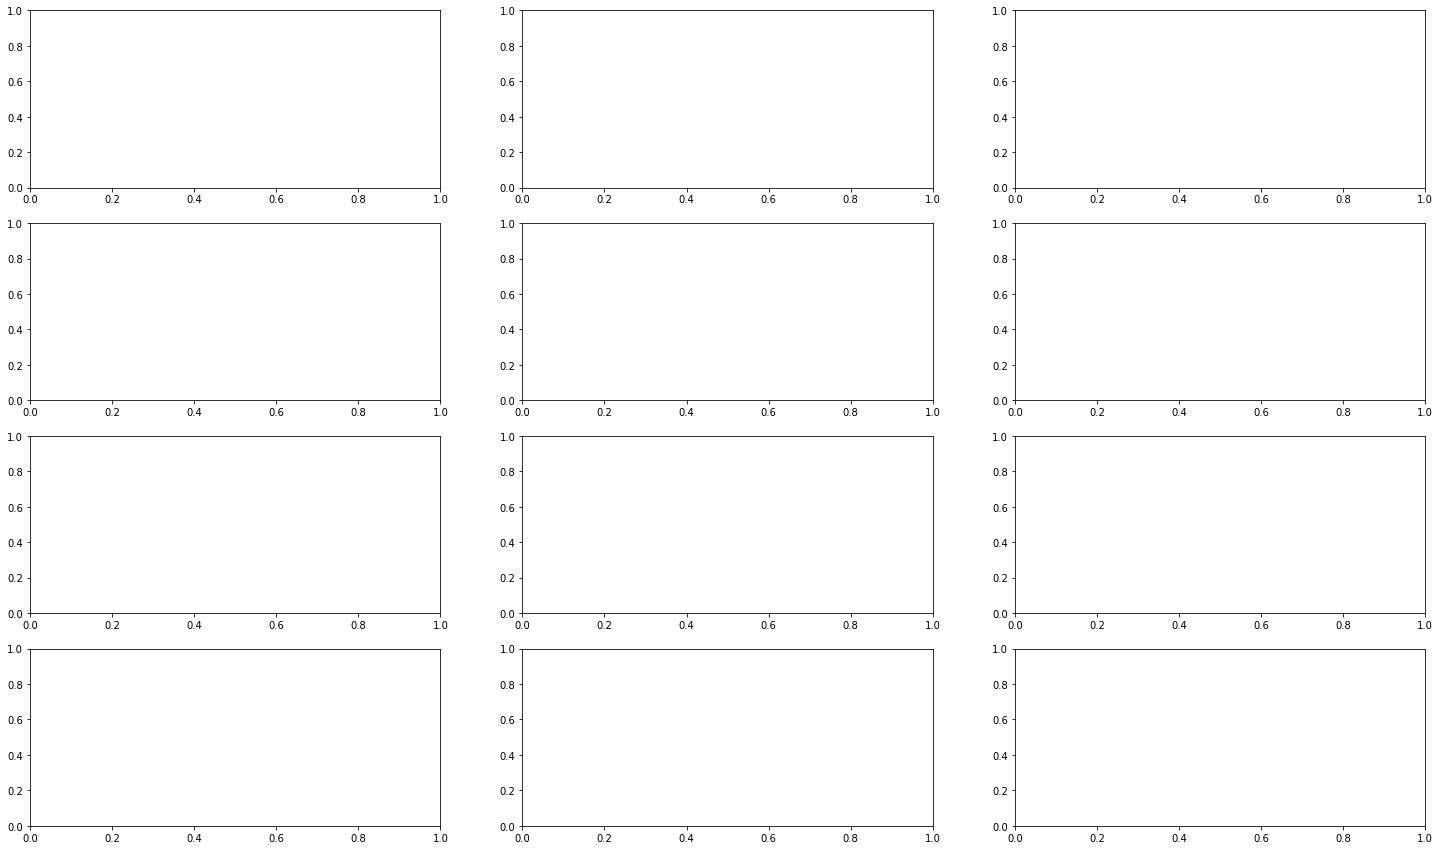

In [25]:
import seaborn as sns
fig, axes = plt.subplots(ncols=3, nrows = 4, figsize=(25, 15))
ax = axes.flatten()
homes = [0, 4, 8, 12]
appliance = 'dr'
idx = ORDER.index(appliance)
fold_num = 0

for i, home_id in enumerate(homes):
    sns.heatmap(pred[idx].reshape(-1, 112, 24)[home_id], ax=ax[i*3], cmap='Greens')
    sns.heatmap(test_gt_fold[idx].reshape(-1 ,112, 24)[home_id], ax=ax[i*3+1], cmap='Greens')
    sns.heatmap(test_aggregate[home_id][0], ax=ax[i*3+2], cmap='Greens')